# Import libraries and train the model

In [27]:
from imutils import paths

In [28]:
import numpy as np 
import os 
import matplotlib.pyplot as plt

In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [31]:
dataset='Mask Dataset'
imagePaths=list(paths.list_images(dataset))

In [34]:
data = []
labels = []

for i in imagePaths:
  label = i.split(os.path.sep)[-2]
  labels.append(label)
  image  = load_img(i,target_size=(224,224)) #all the image will be converted to size 224*224
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)

In [35]:
data = np.array(data,dtype='float32')
labels = np.array(labels)

In [36]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [37]:
train_x,test_x,train_y,test_y = train_test_split(data,labels,test_size=0.20,random_state=10,stratify=labels)

In [38]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [39]:
from tensorflow.keras.layers import AveragePooling2D

In [40]:
baseModel = MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3))) #downloading mobilenetv2 excludding top layeer and changing the imput size

In [41]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [42]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)


for layer in baseModel.layers:
    layer.trainable=False


# print(model.summary())

learning_rate=0.001
Epochs=20
BS=12

opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

H=model.fit(
    aug.flow(train_x,train_y,batch_size=BS),
    steps_per_epoch=len(train_x)//BS,
    validation_data=(test_x,test_y),
    validation_steps=len(test_x)//BS,
    epochs=Epochs
)


model.save('mobilenet_v2.model')

e:\face mask detection transfer learning\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
91/91 [==============================] - 48s 431ms/step - loss: 0.2042 - accuracy: 0.9256 - val_loss: 0.0476 - val_accuracy: 0.9819
Epoch 2/20
91/91 [==============================] - 44s 487ms/step - loss: 0.0708 - accuracy: 0.9733 - val_loss: 0.0410 - val_accuracy: 0.9891
Epoch 3/20
91/91 [==============================] - 43s 476ms/step - loss: 0.0594 - accuracy: 0.9816 - val_loss: 0.0582 - val_accuracy: 0.9674
Epoch 4/20
91/91 [==============================] - 41s 453ms/step - loss: 0.0491 - accuracy: 0.9816 - val_loss: 0.0335 - val_accuracy: 0.9819
Epoch 5/20
91/91 [==============================] - 40s 438ms/step - loss: 0.0397 - accuracy: 0.9890 - val_loss: 0.0260 - val_accuracy: 0.9928
Epoch 6/20
91/91 [==============================] - 41s 451ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0224 - val_accuracy: 0.9928
Epoch 7/20
91/91 [==============================] - 41s 454ms/step - loss: 0.0314 - accuracy: 0.9890 - val_loss: 0.0217 - val_accuracy: 0.9964

e:\face mask detection transfer learning\venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: mobilenet_v2.model\assets


In [43]:
from sklearn.metrics import classification_report

In [44]:
predict=model.predict(test_x,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_y.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.98      0.99       138
without_mask       0.98      1.00      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



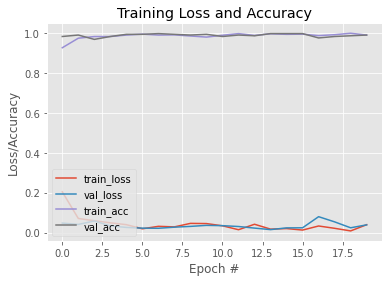

In [45]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot_v2.png')

# Test the model 

In [46]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os

## Import caffee model and prototxt for face detection instead of haarcascade 

In [47]:
prototxtPath=os.path.sep.join(['deploy.prototxt'])
weightsPath=os.path.sep.join(['res10_300x300_ssd_iter_140000.caffemodel'])

In [48]:
net=cv2.dnn.readNet(prototxtPath,weightsPath)

In [49]:
model=load_model('mobilenet_v2.model')

## Face mask detection from image

In [52]:
image=cv2.imread('binil.jpg')

In [53]:
(h,w)=image.shape[:2]

blob=cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))

net.setInput(blob)
detections=net.forward()

In [54]:
#loop over the detections
for i in range(0,detections.shape[2]):
    confidence=detections[0,0,i,2]
    
    
    if confidence>0.5:
        #we need the X,Y coordinates
        box=detections[0,0,i,3:7]*np.array([w,h,w,h])
        (startX,startY,endX,endY)=box.astype('int')
        
        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))
        
        
        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=image[startY:endY, startX:endX]
        face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        face=cv2.resize(face,(224,224))
        face=img_to_array(face)
        face=preprocess_input(face)
        face=np.expand_dims(face,axis=0)
        
        (mask,withoutMask)=model.predict(face)[0]
        
        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)
        
        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)
        
        #display the label and bounding boxes
        cv2.putText(image,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
        
        
        
cv2.imshow("OutPut",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Face mask detection from video

In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
from imutils.video import VideoStream
import imutils

In [ ]:


def detect_and_predict_mask(frame,faceNet,maskNet):
    #grab the dimensions of the frame and then construct a blob
    (h,w)=frame.shape[:2]
    blob=cv2.dnn.blobFromImage(frame,1.0,(300,300),(104.0,177.0,123.0))
    
    faceNet.setInput(blob)
    detections=faceNet.forward()
    
    #initialize our list of faces, their corresponding locations and list of predictions
    
    faces=[]
    locs=[]
    preds=[]
    
    
    for i in range(0,detections.shape[2]):
        confidence=detections[0,0,i,2]
    
    
        if confidence>0.5:
        #we need the X,Y coordinates
            box=detections[0,0,i,3:7]*np.array([w,h,w,h])
            (startX,startY,endX,endY)=box.astype('int')
        
            #ensure the bounding boxes fall within the dimensions of the frame
            (startX,startY)=(max(0,startX),max(0,startY))
            (endX,endY)=(min(w-1,endX), min(h-1,endY))
        
            #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
            face=frame[startY:endY, startX:endX]
            face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
            face=cv2.resize(face,(224,224))
            face=img_to_array(face)
            face=preprocess_input(face)
        
            faces.append(face)
            locs.append((startX,startY,endX,endY))
        
        #only make a predictions if atleast one face was detected
        if len(faces)>0:
            faces=np.array(faces,dtype='float32')
            preds=maskNet.predict(faces,batch_size=12)
        
        return (locs,preds)



prototxtPath=os.path.sep.join(['deploy.prototxt'])
weightsPath=os.path.sep.join(['res10_300x300_ssd_iter_140000.caffemodel'])


faceNet=cv2.dnn.readNet(prototxtPath,weightsPath)


maskNet=load_model('mobilenet_v2.model')


vs=VideoStream(src=0).start()

while True:
    #grab the frame from the threaded video stream and resize it
    #to have a maximum width of 400 pixels
    frame=vs.read()
    frame=imutils.resize(frame,width=400)
    
    #detect faces in the frame and preict if they are waring masks or not
    (locs,preds)=detect_and_predict_mask(frame,faceNet,maskNet)
    
    #loop over the detected face locations and their corrosponding loactions
    
    for (box,pred) in zip(locs,preds):
        (startX,startY,endX,endY)=box
        (mask,withoutMask)=pred
        
        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)
        
        #display the label and bounding boxes
        cv2.putText(frame,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        
        cv2.rectangle(frame,(startX,startY),(endX,endY),color,2)
        
    #show the output frame
    cv2.imshow("Frame",frame)
    key=cv2.waitKey(1) & 0xFF
    
    if key==ord('q'):
        break
        
cv2.destroyAllWindows()
vs.stop()